# Word-Level 번역기
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

<br>

## 데이터 로드 및 전처리
- 기계 번역기를 훈려시키기 위해서 훈 련 데이터로 병렬 코퍼스 (parallel corpus)가 필요
  - **병렬 코퍼스 : 2개 이상의 언어가 병력적으로 구성된 코퍼스**

In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
! wget http://www.manythings.org/anki/fra-eng.zip

--2024-02-11 16:37:22--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  5.69MB/s    in 1.3s    

2024-02-11 16:37:24 (5.69 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [ ]:
! unzip fra-eng.zip -d fra-eng

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


- 19만개의 데이터 중 33,000개의 샘플만을 사용

In [ ]:
num_samples = 33000

<br>

### 전처리 함수 구현

<br>

-  프랑스어 악센트(accent) 삭제
  - 예시 : 'déjà diné' -> deja dine

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

<br>

- 구두점 전처리
  - 단어와 구두점 사이에 공백을 생성 : (Ex) "he is a boy." => "he is a boy .")
  - (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.

In [ ]:
def preprocess_sentence(sent):
  sent = unicode_to_ascii(sent.lower())

  sent = re.sub(r"([?.!,¿])", r" \1", sent)
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
  sent = re.sub(r"\s+", " ", sent)
  return sent

<br>

- 전처리 함수 테스트

In [ ]:
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


<br>

### 교사 강요
- **훈련 과정에서는 이전 시점의 디코더 셀의 출력을, 현재 시점의 디코더 셀의 입력으로 넣어주지 않고,**

  **이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 함**

  $→$ **이전 시점의 디코더 셀의 예측이 틀렸는데, 이를 현재 시점의 디코더 셀의 입력으로 사용하면, 연쇄적으로 디코더 전체의 예측을 어렵게 함**

  $→$ **이런 상황이 반복될 시, 훈련 시간이 느려짐**

  $→$ **이를 방지하기 위하여, 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법 사용**

<br>

- 전체 데이터에서 33,000개의 샘플에 대해 전처리 수행
- 훈련 과정에서 교사 강요 (Teaching Force)를 위하여, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값.

  **즉, 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장**

- 입력 시퀀스에는 시작을 의미하는 \<sos\>를 추가, 출력 시퀀스에는 종료를 의미하는 \<eos\>를 추가

In [ ]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("./fra-eng/fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

In [ ]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

In [ ]:
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


<br>

#### 토크나이저, 정수 인코딩, 패딩

In [ ]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


<br>

#### 각 언어별 단어 집합의 크기 정의

In [ ]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4487, 프랑스어 단어 집합의 크기 : 7883


<br>

- 단어 집합의 크기는 각각 4,647개와 8,022개

  $→$ 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 생성

In [ ]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

- 순서가 섞인 정수 시퀀스 리스트 생성

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [29128 11954 10751 ...  3591 17532   346]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- decoder_input과 decoder_target은 데이터의 구조상으로 앞에 붙은 \<sos\>토큰과 뒤에 붙은 \<eos\>를 제외하면 동일한 정수 시퀀스를 가짐

In [ ]:
encoder_input[30997]

array([   3,   28, 2376,    1,    0,    0,    0], dtype=int32)

In [ ]:
decoder_input[30997]

array([   2,    9,   58,   51, 3211,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
decoder_target[30997]

array([   9,   58,   51, 3211,    1,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

<br>

#### 훈련/테스트 데이터 분리

In [ ]:
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 3300


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


<br>

## 기계 번역기 생성

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
embedding_dim = 64
hidden_units = 64

<br>

### 인코더
- 인코더의 내부 상태를 디코더로 넘겨주어야 하기에 `return_state=True`로 설정
  - 인코더에 입력을 넣으면 내부 상태를 리턴
- **LSTM에서 리턴받는 `state_h`, `state_c`은 각각 은닉 상태와 셀 상태에 해당**

  $→$ **이 두 가지 상태를 `encoder_states`에 저장**

  $→$ **`encoder_states`를 디코더에 전달 (두 가지 상태를 디코더로 전달) $→$ 컨텍스트 벡터**

In [ ]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

<br>

### 디코더
- **디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻음**
(`initial_stae = encoder_states`)
- 훈련 과정에서 디코더의 은닉 상태, 셀 상태는 사용하지 않음

- **seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류를 진행**
  - 매 시점마다 프랑스어 단어 집합의 크기 (`tar_vocab_size`)의 선택지에서 단어를 1개 선택하여, 이를 이번 시점에서 예측한 단어로 선택
  
    (소프트맥스 함수, 크로스 엔트로피 손실함수)

In [ ]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

<br>

- `loss`를 `categorical_crossentropy`를 사용하려면 레이블은 원-핫 이코딩이 된 상태여야 함

  $→$ `decoder_outputs`의 경우 원-핫 이코딩이 되지 않음

  $→$ **원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제로 풀고자 하는 경우에는 `loss`=`sparse_categorical_crossentropy`를 사용**

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 64)             287168    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 64)             504512    ['input_2[0][0]']             
                                                                                              

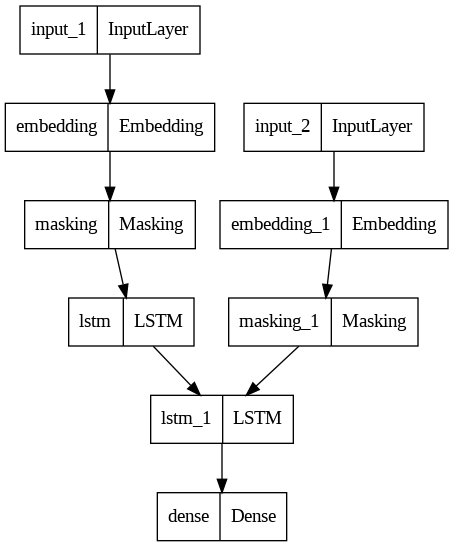

In [ ]:
plot_model(model, show_layer_names=True)

<br>

### 모델 적합

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50, verbose=False)

<br>

### seq2seq 기계 번역기 동작
* **seq2seq는 훈련할 때와 동작할 때의 방식이 다름**

<br>

**전체적인 번역 동작 단계**
```
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻음
2. 상태와 <SOS>에 해당하는 '\t'를 디코더로 전송
3. 디코더가 <EOS>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복
```


<br>

#### 인코더 정의
- `encoder_inputs`와 `encoder_states`는 훈련 과정에서 이미 정의한 것들을 재사용

  - 훈련 단계에 `encoder_inputs`와 `encoder_states`사이에 있는 모든 층까지 전부 불러옴

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

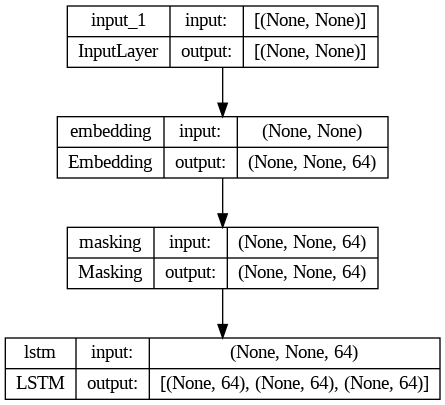

In [ ]:
plot_model(encoder_model, show_shapes=True)

<br>

#### 디코더 정의
- **테스트 단계에서는 디코더를 매 시점 별로 컨트롤해야 하므로,**

  **이전 시점의 상태를 저장하는 객체(`decoder_state_input_h`, `decoder_state_input_c`)를 정의해야함**


In [ ]:
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

- 수정된 디코더

In [ ]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

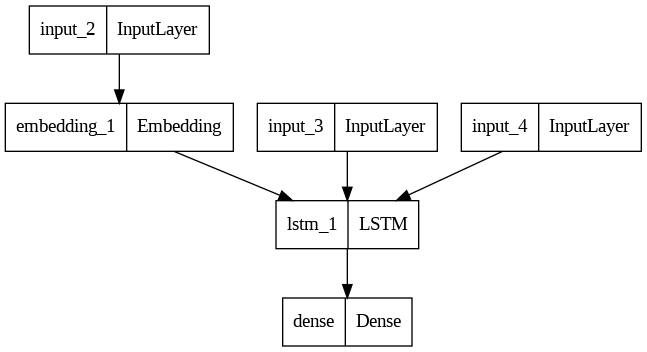

In [ ]:
plot_model(decoder_model)

<br>

### 번역기 동작 함수
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여, 마지막 시점의 은닉 상태와 셀 상태를 리턴
2. 두 개의 값을 `states_value`에 저장
3. 디코더의 초기 입력으로 \<sos\>를 준비 후, `target_seq`에 저장
4. 두 가지 입력을 가지고 반복문으로 진입하여, 이 두가지를 디코더의 입력으로 사용
5. 디코더에 예측에 있어, 현재 시점의 예측 벡터가 `output_tokens`, 현재 시점의 은닉 상태가 `h`, 현재 시점의 셀 상태가 `c`
6. 예측 벡터로부터 현재 시점의 예측 단어인 `target_seq`를 얻고, `h`와 `c`의 값은 `states_value`에 저장
7. 다음 루프에서 디코더에 입력으로 다시 `target_seq`와 `states_value`를 사용
8. 예측 단어로 \<eos\>가 나오거나, 번역 문장의 길이가 50이 넘으면 중단

In [ ]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

<br>

### 결과 확인
- 영어 문장에 해당하는 정수 시퀀스를 입력받으면, 정수로부터 영어 단어를 리턴하는 함수

In [ ]:
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word!=0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

- 프랑스어에 해당하는 정수 시퀀스를 입력받으면, 정수로부터 프랑스어 단어를 리턴하는 함수

In [ ]:
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word!=0 and encoded_word!=tar_to_index['<sos>'] and encoded_word!=tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

<br>

#### 결과 확인

In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 19ms/step
입력문장 : we met that night . 
정답문장 : nous nous sommes rencontres cette nuit la . 
번역문장 : nous nous sommes rencontres la realite . 
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : we were too late . 
정답문장 : nous arrivames trop tard . 
번역문장 : nous avons ete trop vieux . 
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : i m not like you . 
정답문장 : je ne suis pas comme vous . 
번역문장 : je ne suis pas comme toi . 
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : i paid for them . 
정답문장 : j ai paye pour eux . 
번역문장 : j ai paye pour eux . 
--------------------------------------------------
1/1 [==============================] - 0s 22ms/step
입력문장 : tom is too nosey . 
정답문장 : tom est trop curieux . 
번역문장 : tom est trop . 
----------------------------------------------

In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 18ms/step
입력문장 : i never went back . 
정답문장 : je n y suis jamais retournee . 
번역문장 : je ne suis pas a reveille courir . 
--------------------------------------------------
1/1 [==============================] - 0s 29ms/step
입력문장 : try to calm down . 
정답문장 : essaie de te calmer . 
번역문장 : essaie de calme . 
--------------------------------------------------
1/1 [==============================] - 0s 40ms/step
입력문장 : let tom decide . 
정답문장 : laisse tom decider . 
번역문장 : laissez tom decider . 
--------------------------------------------------
1/1 [==============================] - 0s 32ms/step
입력문장 : we ll miss you . 
정답문장 : tu vas nous manquer . 
번역문장 : tu nous manqueras . 
--------------------------------------------------
1/1 [==============================] - 0s 31ms/step
입력문장 : a revolt broke out . 
정답문장 : une revolte eclata . 
번역문장 : un bateau s est la . 
--------------------------------------------------


<br>

## BLEU Score (Bilingual Evaluation Understudy Score)
- 언어 모델의 성능 측정을 위한 평가 받법으로 PPL (perplexity)가 있지만,

  기계 번역기에서 직접적인 평가 성능으로 사용하기 어려움

- BLEU는 기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 지표

In [58]:
import numpy as np
from collections import Counter
from nltk import ngrams

<br>

### BLEU (Bilingual Evaluation Understudy)
- **BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역 성능을 측정하는 방법**
  - **측정 기준은 n-gram에 기반**

- BLEU의 이점
  - 언어에 구애받지 않고 사용
  - 빠른 계산 속도
  - 점수가 높을수록 성능이 좋음을 의미

<br>


### 1) 유니그램 정밀도 (Unigram Precision) : 단어 개수 카운트로 측정

> 한국어-영어 번역기의 성능을 측정한다고 가정.
>
> 두 개의 기계 번역기가 존재하고 두 기계 번역기에 같은 한국어 문장을 입력하여 번역된 영어 문장의 성능을 측정
>
> 번역된 문장은 각각 Candidate1, 2라고 명명
>
> ```
Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.
```

> 이 문장의 성능을 평가하기 위해서는 정답으로 비교되는 문장이 있어야 필요
>
> 세 명의 사람에게 한국어를 보고 영작해보라고 하여 세 개의 번역 문장을 생성하고, 이 세 문장을 각각 Reference1, 2, 3라고 명명
>
> ```
Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
Reference3 : It is the practical guide for the army always to heed the directions of the party.
```

<br>

#### 유니그램 정밀도 (Unigram Precision)
- Ca 1, 2를 Ref 1, 2, 3과 비교하여 성능을 측정하고자 할 때,

  가장 직관적인 성능 평가 방법은 Ref 1, 2, 3 중 어느 한 문장이라도 등장한 단어의 개수를 Ca에서 세는 것

  그 후 Ca의 모든 단어의 카운트의 합, 즉 Ca에서의 총 단어의 수로 나누어줌


$$\text{Unigram Precision =}\frac{\text{Ref들 중에서 존재하는 Ca의 단어의 수}}{\text{Ca의 총 단어 수}} = \frac{\text{the number of Ca words(unigrams) which occur in any Ref}}{\text{the total number of words in the Ca}}$$

<br>

- Ca 1이 Ca 2보다 더 좋은 번역 문장

$$\text{Ca1 Unigram Precision =} \frac{17}{18}$$

$$\text{Ca2 Unigram Precision =} \frac{8}{14}$$

<br>

### 2) 보정된 유니그램 정밀도 (Modified Unigram Precision) : 중복을 제거하여 보정

- Ca와 Ref가 아래와 같을 때,

> ```
Candidate : the the the the the the the
Reference1 : the cat is on the mat
Reference2 : there is a cat on the mat
```

<br>

- **Ca는 'the'만 7개가 등장한 좋지 않은 번역임에도, 유니그램 정밀도에 따르면 $\frac{7}{7}=1$로써 좋은 성능 평가를 받게됨**

  $→$ **이를 보정하기 위하여 정밀도의 분자를 계산하기 위해 Ref와 매칭하며,
    카운트하는 과정에서 Ca의 유니그램이 이미 Ref에서 매칭된 적이 있었는지를 고려**

$$\text{Unigram Precision =}\frac{\text{Ref들과 Ca를 고려한 새로운 카운트 방법이 필요!}}{\text{Ca의 총 유니그램 수}}$$

<br>

#### 보정된 유니그램 정밀도 (Modified Unigram Precision)
- 정밀도의 분자를 계산하기 위한 각 유니그램의 카운트의 수정 :
  - $Max\_Ref\_Count$ : 유니그램이 하나의 Ref에서 최대 몇 번 등장했는지를 카운트
  - $Max\_Ref\_Count$가 기존의 단순 카운트한 값보다 작은 경우에는 이 값을 최종 카운트의 값으로 대체
- 정밀도의 분자 계산을 위한 새로운 카운트 방식

$$Count_{clip}\ =\ min(Count,\ Max\_Ref\_Count)$$

<br>

$$\text{Modified Unigram Precision =}\frac{\text{Ca의 각 유니그램에 대해 }Count_{clip}\text{을 수행한 값의 총 합}}{\text{Ca의 총 유니그램 수}}=\frac{\sum_{unigram∈Candidate}\ Count_{clip}(unigram)}
{\sum_{unigram∈Candidate}\ Count(unigram)}$$

<br>

- 'the'의 경우 Ref 1에서 총 2번 등장 $→$ 'the'의 카운트는 2로 보정
- Ca의 기존 유니그램 정밀도는 $\frac{7}{7}=1$이었으나, 보정된 유니그램 정밀도는 $\frac{2}{7}$로 변경

<br>

- Ca 1에서 'the'는 3번 등장, Ref 2와 Ref 3에서 'the'가 4번 등장

  $→$ 3은 4보다 작으므로 'the'는 3으로 카운트

  $→$ 'the'외에 Ca 1의 모든 유니그램은 전부 1개씩 등장하므로 보정 전과 동일하게 카운트

> ```
Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
```
>
> ```
Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
Reference3 : It is the practical guide for the army always to heed the directions of the party.
```

<br>

### 3) 보정된 유니그램 정밀도 (Modified Unigram Precision) 구현
- **유니그램을 단순히 카운트하는 함수 :**
  - 토큰화 된 문장(tokens)을 입력받아서 문장 내의 n-gram을 카운트

In [59]:
def simple_count(tokens, n):
  return Counter(ngrams(tokens, n))

In [61]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split()
result = simple_count(tokens, 1)
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


In [62]:
candidate = 'the the the the the the the'
tokens = candidate.split()
result = simple_count(tokens, 1)
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 7})


<br>

- **$Count_{clip}$ 구현 함수**

In [63]:
def count_clip(candidate, reference_list, n):
  # Ca 문장에서 n-gram 카운트
  ca_cnt = simple_count(candidate, n)
  max_ref_cnt_dict = dict()

  for ref in reference_list:
    # Ref 문장에서 n-gram 카운트
    ref_cnt = simple_count(ref, n)

    # 각 Ref 문장에 대해서 비교하여 n-gram의 최대 등장 횟수를 계산.
    for n_gram in ref_cnt:
      if n_gram in max_ref_cnt_dict:
        max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
      else:
        max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

  return {
        # count_clip = min(count, max_ref_count)
        n_gram: min(ca_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in ca_cnt
     }

In [65]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]

In [66]:
result = count_clip(candidate.split(), list(map(lambda ref: ref.split(), references)), 1)
print('보정된 유니그램 카운트 :',result)

보정된 유니그램 카운트 : {('the',): 2}


<br>

- 보정된 유니그램 정밀도 구현 함수

In [67]:
def modified_precision(candidate, reference_list, n):
  clip_cnt = count_clip(candidate, reference_list, n)
  total_clip_cnt = sum(clip_cnt.values()) # 분자

  cnt = simple_count(candidate, n)
  total_cnt = sum(cnt.values()) # 분모

  # 분모가 0이 되는 것을 방지
  if total_cnt == 0:
    total_cnt = 1

  # 분자 : count_clip의 합, 분모 : 단순 count의 합 ==> 보정된 정밀도
  return (total_clip_cnt / total_cnt)

In [68]:
result = modified_precision(candidate.split(), list(map(lambda ref: ref.split(), references)), n=1)
print('보정된 유니그램 정밀도 :',result)

보정된 유니그램 정밀도 : 0.2857142857142857


<br>

### 4) BLEU : 순서를 고려하기 위해서 n-gram으로 확장
- BoW 표현과 유사하게, 유니그램 정밀도와 같이 각 단어의 빈도수로 접근하는 방법은 단어의 순서를 고려하지 않음

<br>

- Ca 3은 Ca 1에서 모든 유니그램의 순서를 랜덤으로 섞은 문장

  하지만, Ref 1, 2, 3과 비교하여 유니그램 정밀도를 적용하면, Ca 1과 Ca 3의 두 정밀도는 동일

  **유니그램 정밀도는 유니그램의 순서를 전혀 고려하지 않기 때문**

> ```
Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.
Candidate3 : the that military a is It guide ensures which to commands the of action obeys always party the.
```

>

> ```
Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
Reference3 : It is the practical guide for the army always to heed the directions of the party.
```


- 이를 위한 대안으로 개별적인 유니그램/단어로서 카운트하는 유니그램 정밀도에서 다음에 등장한 단어까지 함께 고려하여 카운트

  $→$ 유니그램 외에도 Bigram, Trigram, 4-gram 단위 등으로 계산한 정밀도. 즉, n-gram을 이용

  $\rightarrow$ 카운트 단위를 2개, 3개, 4개로 보느냐의 차이로 2-gram Precision, 3-gram Precision, 4-gram Precision으로 취급

<br>

- Ca와 Ref가 아래와 같을 때

> ```
Candidate1 : the the the the the the the
Candidate2 : the cat the cat on the mat
```

> ```
Reference1 : the cat is on the mat
Reference2 : there is a cat on the mat
```

- Ca 2 바이그램의 $Count$와 $Count_{clip}$
  - Ca 2의 바이그램 정밀도는 $\frac{4}{6}$, Ca 1의 바이그램 정밀도는 0

<table>
<thead>
<tr>
<th>바이그램</th>
<th>the cat</th>
<th>cat the</th>
<th>cat on</th>
<th>on the</th>
<th>the mat</th>
<th>SUM</th>
</tr>
</thead>
<tbody>
<tr>
<td>$Count$</td>
<td>2</td>
<td>1</td>
<td>1</td>
<td>1</td>
<td>1</td>
<td><strong>6</strong></td>
</tr>
<tr>
<td>$Count_{clip}$</td>
<td>1</td>
<td>0</td>
<td>1</td>
<td>1</td>
<td>1</td>
<td><strong>4</strong></td>
</tr>
</tbody>
</table>

<br>

- **보정된 유니그램 정밀도의 식**

$$p_{1}=\frac{\sum_{unigram∈Candidate}\ Count_{clip}(unigram)}
{\sum_{unigram∈Candidate}\ Count(unigram)}$$

<br>

- **n-gram으로 일반화**

$$p_{n}=\frac{\sum_{n\text{-}gram∈Candidate}\ Count_{clip}(n\text{-}gram)}
{\sum_{n\text{-}gram∈Candidate}\ Count(n\text{-}gram)}$$

<br>

#### BLEU
- **BLEU는 보정된 정밀도 $p_1, \dots, p_n$을 모두 조합하여 사용**
  - $p_n$ : 각 gram의 보정된 정밀도
  - $N$ : n-gram에서 $n$의 최대 숫자 (보통 4의 값, $p_1, \dots p_4$)
  - $w_n$ : 각 그램의 보정된 정밀도에 서로 다른 가중치를 부여
    - 가중치의 합은 1
    - 예를 들어 $N=4$일 때, $p_1, \dots, p_4$에 대해서 동일한 가중치를 주고자 한다면 모두 0.25를 적용


$$BLEU = exp(\sum_{n=1}^{N}w_{n}\ \text{log}\ p_{n})$$

<br>

### 5) 브레버티 페널티 (Brevity Penalty) : 짧은 문장 길이에 대한 페널티
- **n-gram으로 단어의 순서를 고려한다고 하더라도,Ca의 길이에 BLEU의 점수가 과한 영향을 받을 수 있음**

<br>

- **Ca 4의 유니그램 정밀도나 바이그램 정밀도는 모두 1이라는 높은 값**

  $→$ **Ca가 Ref 보다 문장의 길이가 짧은 경우에는 점수에 페널티를 부여 브레버티 페널티 (Brevity Penalty)**
  
> ```
Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.
Candidate3 : the that military a is It guide ensures which to commands the of action obeys always party the.
Candidate4 : it is
```

>
> ```
Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
Reference3 : It is the practical guide for the army always to heed the directions of the party.
```

<br>

- Ca 1은 가장 많은 단어를 사용했지만, Ca 2보다 좋지 못한 번역 $→$ **Ref의 단어를 가장 많이 사용한 것이 꼭 좋은 번역이라는 의미가 아님**
- **Ca의 길이가 불필요하게 Ref보다 긴 경우에는 BLEU 수식에서 정밀도를 n-gram으로 확장하여 계산하는 것만으로도 이미 페널티를 받고 있음**

  $→$ **즉, Ca가 Ref보다 긴 경우에는, 브레버티 페널티를 설계할 때 고려할 필요가 없음**
  
> ```
Candidate 1: I always invariably perpetually do.
Candidate 2: I always do.
```

> ```
Reference 1: I always do.
Reference 2: I invariably do.
Reference 3: I perpetually do.
```

<br>

- **Ref보다 Ca의 길이가 짧을 경우, 브레버티 페널티는 BLEU의 식에 곱하는 방식으로 사용**

$$BLEU = BP × exp(\sum_{n=1}^{N}w_{n}\ \text{log}\ p_{n})$$

- **페널티를 줄 필요가 없는 경우에는 $BP$의 값이 1이어야 하므로, BP의 수식은**

$$BP = \begin{cases}1&\text{if}\space c>r\\ e^{(1-r/c)}&\text{if}\space c \leq r \end{cases}$$

- $c$ : Candidate의 길이
- $r$ : Candidate와 가장 길이 차이가 작은 Reference의 길이

<br>

- Ref가 1개라면, Ca와 Ref의 두 문장의 길이만을 가지고 계산
- **Ref가 여러개라면, $r$은 모든 Ref들 중에서 Ca와 가장 길이 차이가 작은 Ref의 길이로 설정**

<br>

- Ca 길이와 가장 근접한 Ref의 길이 $r$을 리턴하는 함수


In [72]:
def closest_ref_length(candidate, reference_list):
  ca_len = len(candidate) # ca 길이
  ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이

  # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
  closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
  return closest_ref_len

<br>

- **만약 Ca와 길이가 정확히 동일한 Ref가 있다면, 길이 차이가 0인 최고 수준의 매치(best match length)**
- **또한 만약 서로 다른 길이의 Ref이지만 Ca와 길이 차이가 동일한 경우에는 더 작은 길이의 Ref를 선택**
  -  Ca가 길이가 10인데, Ref 1, 2가 각각 9와 11이라면 길이 차이는 동일하게 1밖에 나지 않지만 9를 선택
  

<br>

- $BP$를 구하는 함수
  - $c$가 $r$보다 클 경우에는 1을 반환, 그 외의 경우에는 $e^{1-r/c}$를 반환

In [73]:
def brevity_penalty(candidate, reference_list):
  ca_len = len(candidate)
  ref_len = closest_ref_length(candidate, reference_list)

  if ca_len > ref_len:
    return 1

  # candidate가 비어있다면 BP = 0 → BLEU = 0.0
  elif ca_len == 0 :
    return 0
  else:
    return np.exp(1 - ref_len/ca_len)

<br>

- BLEU 점수를 계산하는 함수

In [74]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
  bp = brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP

  p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)]
  # p1, p2, p3, ..., pn
  score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
  return bp * np.exp(score)

<br>

### `NLTK`를 사용한 BLEU 측정



#### `nltk.translate.bleu_score.bleu()`

In [77]:
import nltk.translate.bleu_score as bleu

In [78]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

In [80]:
print('구현 코드의 BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

구현 코드의 BLEU : 0.5045666840058485
패키지 NLTK의 BLEU : 0.5045666840058485
